In [38]:
import os
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

In [39]:
data_info = {
    "1": "Swing",
    "2": "Heel strike",
    "3": "Full contact",
    "4": "Heel off & toe off",
}

class Walk(object):
    def __init__(self, data_type:str, files: list):
        self.data_type = data_type
        self.files = files

walks = []

parent_path = "C:/python/CNN_Multi_Classification/trainingset_ratio_50"
folders = os.listdir(parent_path)

for folder in folders:
    child_path = parent_path + "/" + folder
    files = os.listdir(child_path)
    walks.append(Walk(data_type=folder, files=files))


In [51]:
x = []
y = []

# sigma = 0

for walk in walks:
    for file in walk.files:
        for sigma in range(1, 5):
            try:
                img = cv2.imread(parent_path + "/" + walk.data_type + "/" + file, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (28, 28))
                img = cv2.GaussianBlur(img, (0, 0), sigma)
                data = np.asarray(img)
                
                label = [0 for i in range(4)]
                label[int(walk.data_type) - 1] = 1

                x.append(data)
                y.append(label)
            except Exception as ex:
                print(ex)
                print("ERROR ON " + walk + " " + file)

X = np.array(x)
Y = np.array(y)

print(X.shape)
print(Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.3)

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)
print(y_train.shape)

        

(54540, 28, 28)
(54540, 4)
(38178, 28, 28, 1)
(38178, 4)


In [52]:
input_shape = (28, 28, 1)

model = keras.Sequential([
    keras.Input(shape = input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", input_shape=(28, 28, 1)),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(4, activation="softmax"),
])


# model = keras.Sequential([
#     keras.Input(shape = input_shape),
#     Conv2D(32, kernel_size = (3,3), activation = 'relu', strides=(1,1), padding = 'same'),
#     MaxPooling2D(pool_size = (2,2), strides = (2,2)),
#     Conv2D(64, kernel_size = (3,3), activation = 'relu', strides=(1,1), padding = 'same'),
#     MaxPooling2D(pool_size = (2,2), strides = (2,2)),
#     Conv2D(128, kernel_size = (3,3), activation = 'relu', strides=(1,1), padding = 'same'),
#     MaxPooling2D(pool_size = (2,2), strides = (2,2)),
#     Flatten(),
#     Dense(128, activation= 'relu'),
#     Dense(4, activation = 'softmax'),
# ])

batch_size = 100
epochs = 20

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir + "/walk.model"

checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                

In [54]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[checkpoint, early_stopping])

Epoch 1/20
381/688 [===============>..............] - ETA: 1:07 - loss: 0.3694 - accuracy: 0.8561

128/128 [==============================] - 2s 16ms/step - loss: 0.1423 - accuracy: 0.9401
손실 : 0.1423
정확도 : 0.9401
[0.49677184224128723, 0.3309359550476074, 0.29172444343566895, 0.27162235975265503, 0.2484196424484253, 0.23272934556007385, 0.2285551279783249, 0.215981587767601, 0.2055695801973343, 0.19439589977264404, 0.18761083483695984, 0.18507227301597595, 0.16734063625335693, 0.16905812919139862, 0.16219834983348846, 0.14625036716461182, 0.14419719576835632, 0.13700814545154572, 0.13385629653930664, 0.1288009136915207]


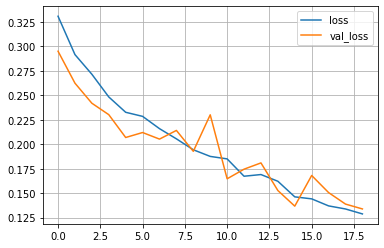

In [49]:
from matplotlib import pyplot as plt

score, acc = model.evaluate(x_test, y_test)

print("손실 : %.4f" % (score))
print("정확도 : %.4f" % (acc))

loss = history.history["loss"]
val_loss = history.history["val_loss"]

print(loss)

plt.plot(loss[1:], label="loss")
plt.plot(val_loss[1:], label="val_loss")

plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import r2_score


y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)

print("R2 Score: %.4f" % r2)